In [1]:
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys

if is_interactive():
    %matplotlib inline
    sys.path.append('../')

import numpy
from sklearn.datasets import make_classification, make_blobs, load_digits
from experiments.data import make_weak_true_partition
from wlc.WLweakener import computeM, weak_to_index, estimate_M
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from experiments.models import create_model, MyKerasClassifier
import inspect
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import cm

from experiments.visualizations import plot_heatmap

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.dpi"] = 100

random_state = 0
numpy.random.seed(random_state)

cmap = cm.get_cmap('Accent')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '+', '-', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

Using Theano backend.


# 1.a. Create synthetic clean dataset

In [2]:
n_classes = 12
n_features = 100
n_samples = 10000

dataset_name = 'digits'

# n_redundant = 0
# n_clusters_per_class = 1
# n_informative = n_features
#X, y = make_classification(n_samples=n_samples, n_features=n_features,
#                           n_classes=n_classes, random_state=random_state,
#                           n_redundant=n_redundant,
#                           n_informative=n_informative,
#                           n_clusters_per_class=n_clusters_per_class)

## Blobs
#true_size = 0.02
#centers = np.random.rand(n_classes, n_features)*2.0
#cluster_std = np.abs(np.random.randn(n_classes)*2.0)
#X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
#                  cluster_std=cluster_std, random_state=random_state)

## Digits
if dataset_name == 'digits':
    true_size = 0.1
    X, y = load_digits(return_X_y=True)
    n_classes = 10
    n_samples = X.shape[0]
    n_features = X.shape[1]
else:
    raise KeyError('Dataset {} not available'.format(dataset_name))

# 1.b. Create synthetic Mixing process

In [3]:
M_method = 'random_weak' # IPL, quasi_IPL, random_weak, random_noise, noisy, supervised
M_alpha = 1.0 # Alpha = 1.0 No unsupervised in IPL
M_beta = 0.5 # Beta = 0.0 No noise

if not is_interactive():
    M_method = sys.argv[1]
    M_alpha = float(sys.argv[2])
    M_beta = float(sys.argv[3])

if M_method != 'IPL':
    M_alpha = 1.0
M = computeM(n_classes, method=M_method, alpha=M_alpha, beta=M_beta,
             seed=random_state)

print(numpy.round(M, decimals=3))

[[0.001 0.001 0.001 ... 0.001 0.001 0.   ]
 [0.001 0.001 0.001 ... 0.001 0.001 0.501]
 [0.001 0.001 0.    ... 0.001 0.501 0.   ]
 ...
 [0.001 0.001 0.001 ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.001 0.001 0.   ]
 [0.    0.001 0.001 ... 0.001 0.001 0.001]]


# 1.c. Create synthetic Weak labels given M

In [4]:
training, validation, test, classes = make_weak_true_partition(M, X, y,
                                                               true_size=true_size,
                                                               random_state=random_state)

X_t, Z_t, z_t, Y_t, y_t = training
X_v, Z_v, z_v, Y_v, y_v = validation

prop_test = 0.8
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_test),
                             test_size=prop_test)

val_indx, test_indx = next(sss.split(X_v, y_v))
print('Weak labels: Training original partition size = {}'.format(len(z_t)))
print('True labels: Validation original partition size = {}'.format(len(val_indx)))
print('True labels: Test original partition size = {}'.format(len(test_indx)))
# test partition
X_te, Z_te, z_te = X_v[test_indx], Z_v[test_indx], z_v[test_indx]
Y_te, y_te = Y_v[test_indx], y_v[test_indx]
# Validation partition
X_v, Z_v, z_v = X_v[val_indx], Z_v[val_indx], z_v[val_indx]
Y_v, y_v = Y_v[val_indx], y_v[val_indx]
print('True labels: Validation partition size = {}'.format(len(y_v)))
print('True labels: Test partition size = {}'.format(len(y_te)))

Weak labels: Training original partition size = 1617
True labels: Validation original partition size = 35
True labels: Test original partition size = 144
True labels: Validation partition size = 35
True labels: Test partition size = 144


# 1.d. Sample of weak and true labels

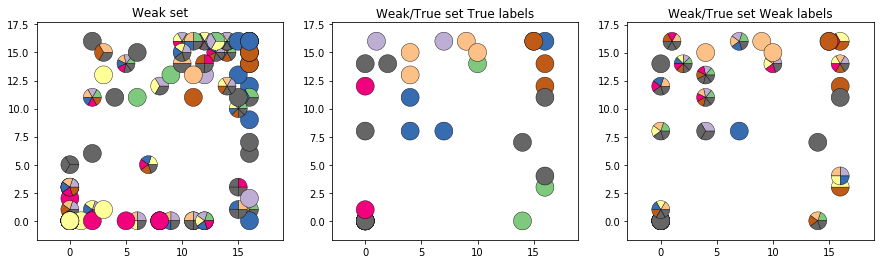

In [5]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X_t[:100, ], Z_t[:100], fig=fig,
                            ax=ax, title='Weak set', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X_v[:100], Y_v[:100], fig=fig,
                            ax=ax, title='Weak/True set True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X_v[:100], Z_v[:100], fig=fig,
                            ax=ax, title='Weak/True set Weak labels', cmap=cmap)

# 2.a. Train Scikit learn baselines

In [6]:
max_epochs = 1000

LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs)
LR.fit(numpy.concatenate((X_t, X_v)), numpy.concatenate((y_t, y_v)))
print('A Logistic Regression trained with all the real labels ({} samples)'.format(y.shape[0]))
acc_upperbound = LR.score(X_te, y_te)
print('Accuracy = {}'.format(acc_upperbound))

LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs)
LR.fit(X_v, y_v)
print('A Logistic Regression trained with only validation true labels ({} samples)'.format(y_v.shape[0]))
acc_lowerbound = LR.score(X_te, y_te)
print('Accuracy = {}'.format(acc_lowerbound))

/home/maikel/git/uob/RecyclingLabels/venv3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


A Logistic Regression trained with all the real labels (1797 samples)
Accuracy = 0.9513888888888888
A Logistic Regression trained with only validation true labels (35 samples)
Accuracy = 0.8055555555555556


# 2.b. Train Keras baselines

## 2.b.1. Upperbound with all true labels available

A Keras Logistic Regression trained with only validation true labels (1652 samples)
Accuracy = 0.9583333333333334


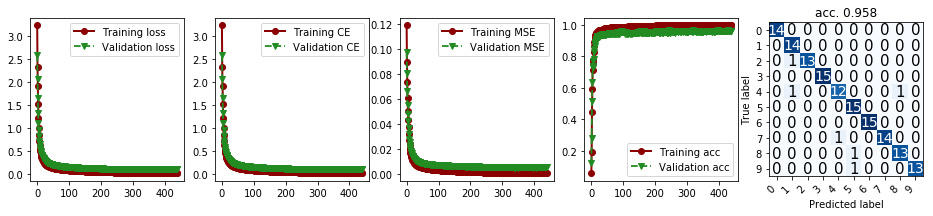

<Figure size 360x288 with 0 Axes>

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

_EPSILON = K.epsilon()

def make_model(loss):
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax',
                bias_initializer='zeros',
                kernel_initializer='random_uniform')) 
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    return model

from keras.callbacks import EarlyStopping

batch_size = 256
patience = 100
early_stop_loss = 'val_mean_squared_error'

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=0, mode='auto', baseline=None,
                               restore_best_weights=True)

numpy.random.seed(random_state)
model = make_model('categorical_crossentropy')

X_tv = numpy.concatenate((X_t, X_v))
Y_tv = numpy.concatenate((Y_t, Y_v))
numpy.random.seed(random_state)
X_tv, Y_tv = shuffle(X_tv, Y_tv)

history = model.fit(X_tv, Y_tv, 
                    validation_split=0.2,
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size)

def plot_results(model, X_test, y_test, history):
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

    from experiments.visualizations import plot_confusion_matrix
    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history['val_loss'], label='Validation loss')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history['val_categorical_crossentropy'], label='Validation CE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history['val_acc'], label='Validation acc')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='acc. {:.3}'.format(acc))
    
plot_results(model, X_te, y_te, history)

print('A Keras Logistic Regression trained with only validation true labels ({} samples)'.format(X_t.shape[0] + X_v.shape[0]))
acc_upperbound = (model.predict_proba(X_te).argmax(axis=1) == y_te).mean()
print('Accuracy = {}'.format(acc_upperbound))

## 2.b.2. Lowerbound with a small amount of true labels

A Keras Logistic Regression trained with only validation true labels (35 samples)
Accuracy = 0.6736111111111112


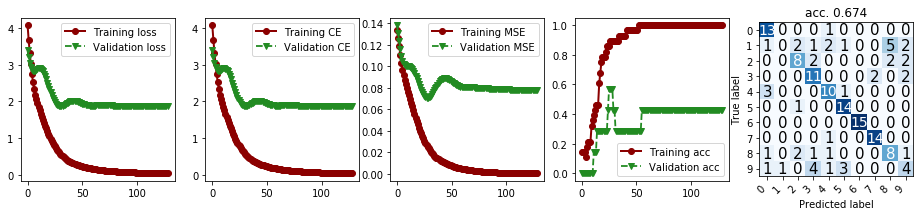

<Figure size 360x288 with 0 Axes>

In [8]:
numpy.random.seed(random_state)
model = make_model('categorical_crossentropy')

history = model.fit(X_v, Y_v, 
                    validation_split=0.2,
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size)

plot_results(model, X_te, y_te, history)

print('A Keras Logistic Regression trained with only validation true labels ({} samples)'.format(X_v.shape[0]))
acc_lowerbound = (model.predict_proba(X_te).argmax(axis=1) == y_te).mean()
print('Accuracy = {}'.format(acc_lowerbound))

## 2.b.3. Training directly with different proportions of weak labels

In [9]:
list_weak_proportions = numpy.array([0.0, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 0.7, 1.0])
acc = {}

Number of weak samples = 1617, Accuracy = 0.840

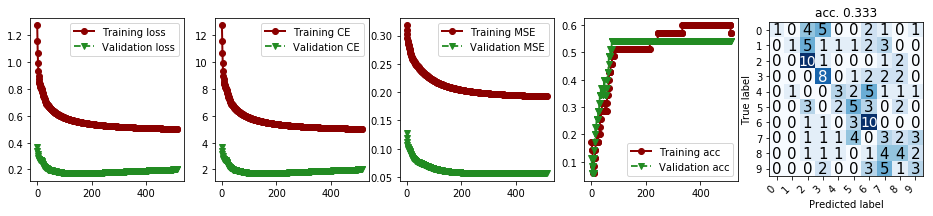

<Figure size 360x288 with 0 Axes>

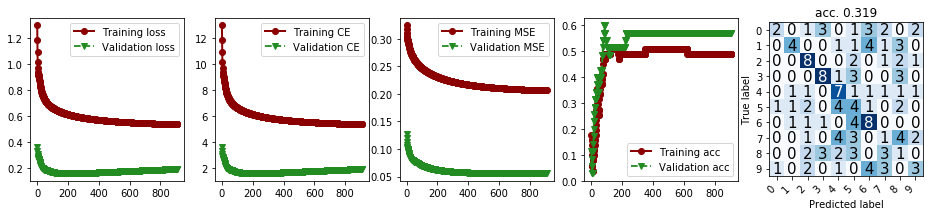

<Figure size 360x288 with 0 Axes>

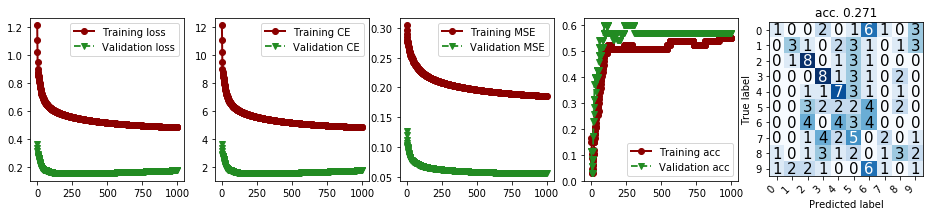

<Figure size 360x288 with 0 Axes>

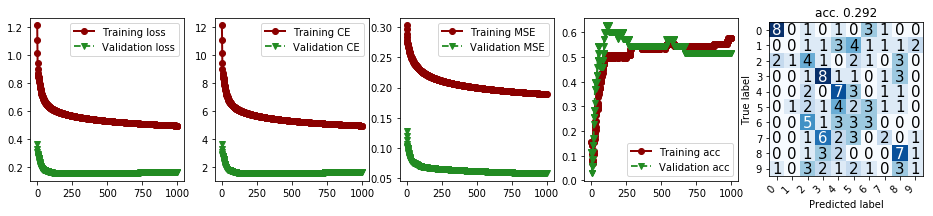

<Figure size 360x288 with 0 Axes>

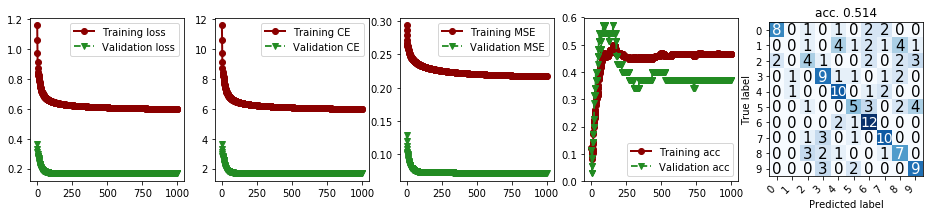

<Figure size 360x288 with 0 Axes>

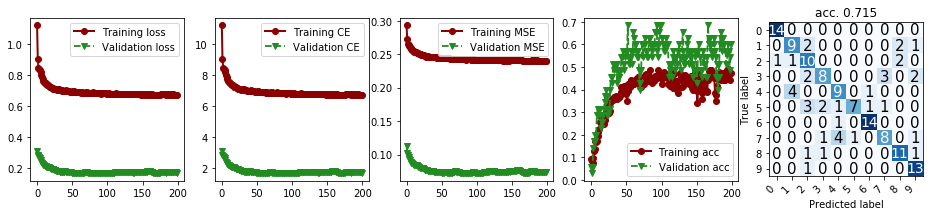

<Figure size 360x288 with 0 Axes>

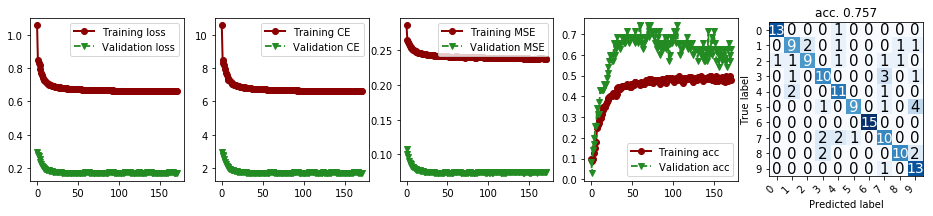

<Figure size 360x288 with 0 Axes>

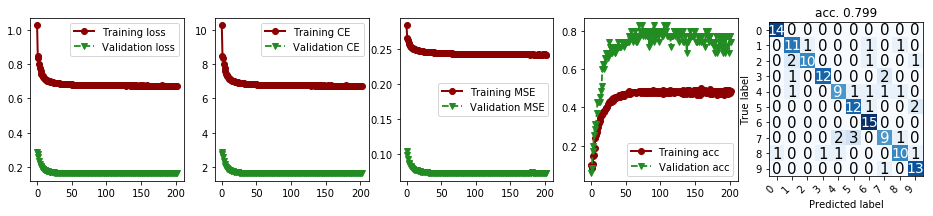

<Figure size 360x288 with 0 Axes>

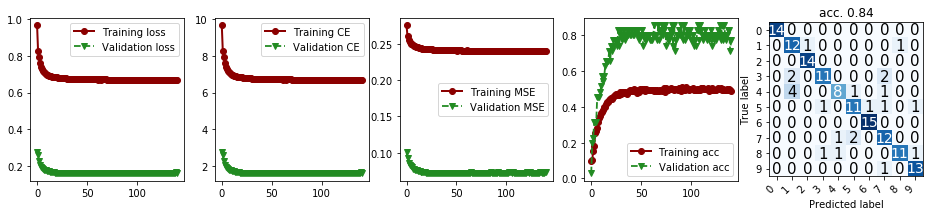

<Figure size 360x288 with 0 Axes>

In [10]:
def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'Weak'
acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_t.shape[0])
    
    X_tv = numpy.concatenate((X_t[:last_index], X_v), axis=0)
    Z_tv = numpy.concatenate((Z_t[:last_index], Z_v), axis=0)
    numpy.random.seed(random_state)
    X_tv, Z_tv = shuffle(X_tv, Z_tv)
    
    numpy.random.seed(random_state)
    model = make_model(log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_tv, Z_tv,
                        validation_data=(X_v, Y_v),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_te).argmax(axis=1)
    acc[method][i] = (y_pred == y_te).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_te, y_te, history)

# 3. Train EM

## 3.a. Learning mixing matrix M

In [11]:
categories = range(n_classes)
# 1.a. Learn a mixing matrix using training with weak and true labels
M_0 = estimate_M(Z_v, Y_v, range(n_classes), reg='Partial', Z_reg=Z_t)
M_1 = computeM(c=n_classes, method='supervised')
q_0 = X_t.shape[0] / float(X_t.shape[0] + X_v.shape[0])
q_1 = X_v.shape[0] / float(X_t.shape[0] + X_v.shape[0])
M_EM = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)
# 1.b. True mixing matrix
M_T = numpy.concatenate((q_0*M, q_1*M_1), axis=0)

print('q0 = {}, q1 = {}'.format(q_0, q_1))
print("M_0\n{}".format(numpy.round(M_0, decimals=3)))
print("M_1\n{}".format(numpy.round(M_1, decimals=3)))
print("M_EM\n{}".format(numpy.round(M_EM, decimals=3)))
print("Z_t\n{}".format(numpy.round(Z_t[:5])))
print("Y_v\n{}".format(numpy.round(Y_v[:5])))

q0 = 0.9788135593220338, q1 = 0.0211864406779661
M_0
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.002 0.002 0.002 ... 0.002 0.002 0.005]
 [0.002 0.002 0.002 ... 0.002 0.005 0.002]
 ...
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]
 [0.002 0.002 0.002 ... 0.002 0.002 0.002]
 [0.    0.    0.    ... 0.    0.    0.   ]]
M_1
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
M_EM
[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.002 0.002 0.002 ... 0.002 0.002 0.005]
 [0.002 0.002 0.002 ... 0.002 0.005 0.002]
 ...
 [0.    0.    0.    ... 0.021 0.    0.   ]
 [0.    0.    0.    ... 0.    0.021 0.   ]
 [0.    0.    0.    ... 0.    0.    0.021]]
Z_t
[[1 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 1 1 0 1 1 1 0 1 0]
 [0 1 

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = 1


## 3.b. Train with true mixing matrix M

In [12]:
m = {}

Z_t_index [656  32 954 274 315]
Y_v_index [4 0 3 1 9]
Number of weak samples = 1617, Accuracy = 0.903

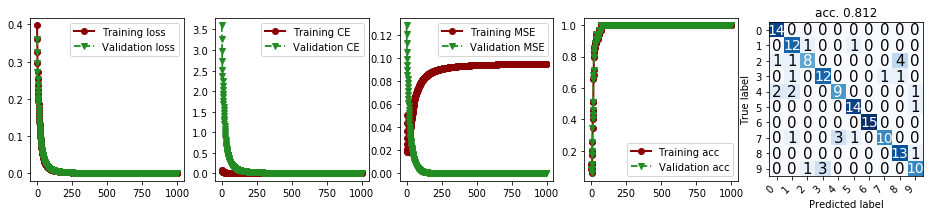

<Figure size 360x288 with 0 Axes>

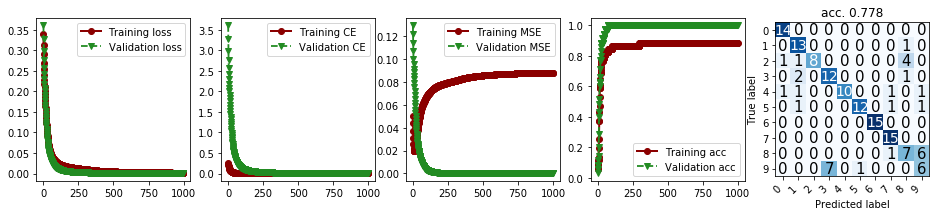

<Figure size 360x288 with 0 Axes>

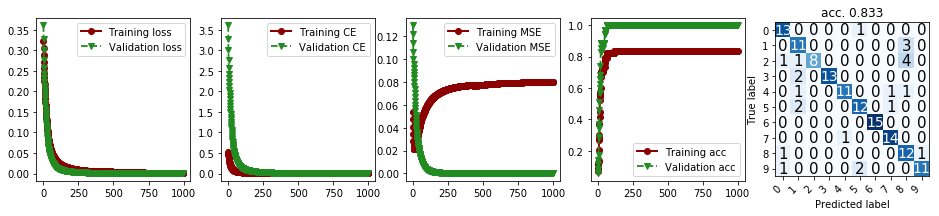

<Figure size 360x288 with 0 Axes>

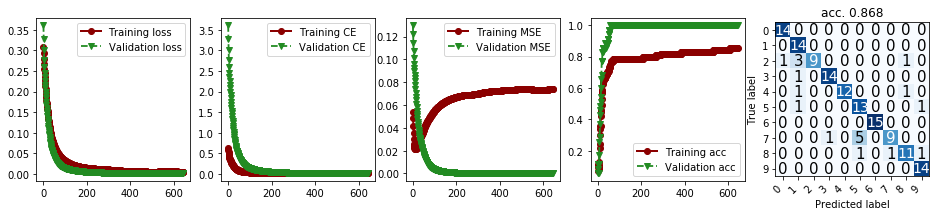

<Figure size 360x288 with 0 Axes>

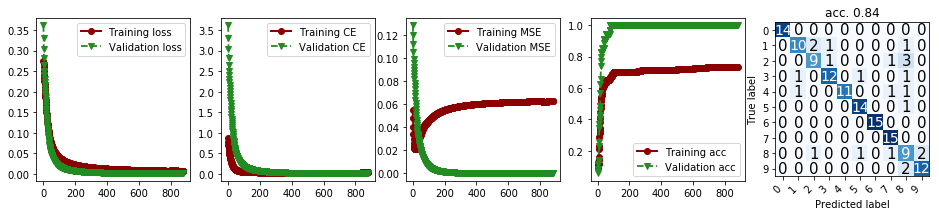

<Figure size 360x288 with 0 Axes>

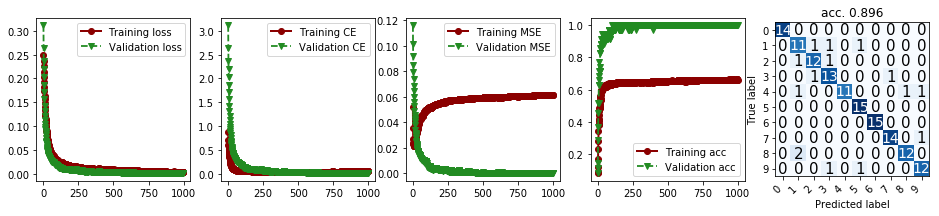

<Figure size 360x288 with 0 Axes>

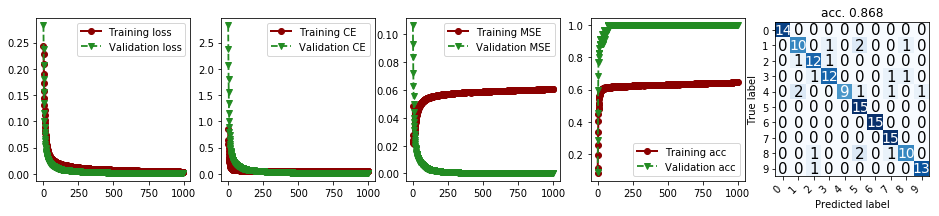

<Figure size 360x288 with 0 Axes>

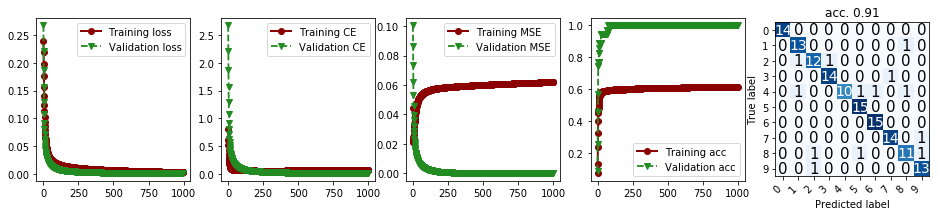

<Figure size 360x288 with 0 Axes>

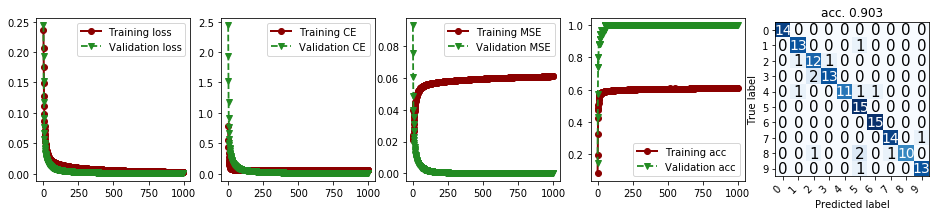

<Figure size 360x288 with 0 Axes>

In [13]:
def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / Q.sum(axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'EM Mproper'

#  2. Compute the index of each sample relating it to the corresponding
#     row of the new mixing matrix
#      - Needs to compute the individual M and their weight q
Z_t_index = weak_to_index(Z_t, method=M_method)
Y_v_index = weak_to_index(Y_v, method='supervised')
print("Z_t_index {}".format(Z_t_index[:5]))
print('Y_v_index {}'.format(Y_v_index[:5]))

acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_T
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_t_index.shape[0])

    Z_index_t = numpy.concatenate((Z_t_index[:last_index], Y_v_index + M.shape[0]))

    X_tv = numpy.concatenate((X_t[:last_index], X_v), axis=0)
    numpy.random.seed(random_state)
    X_tv, Z_index_tv = shuffle(X_tv, Z_index_t)

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_tv, m[method][Z_index_tv], 
                        validation_data=(X_v, Y_v),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_te).argmax(axis=1)
    acc[method][i] = (y_pred == y_te).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_te, y_te, history)

## 3.c. Train with estimated mixing matrix M_ME

Z_t_index [656  32 954 274 315]
Y_v_index [4 0 3 1 9]
Number of weak samples = 1617, Accuracy = 0.938

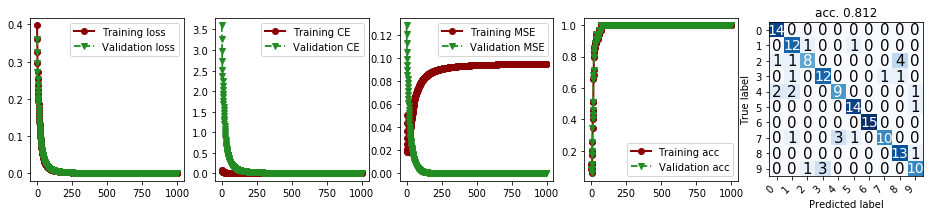

<Figure size 360x288 with 0 Axes>

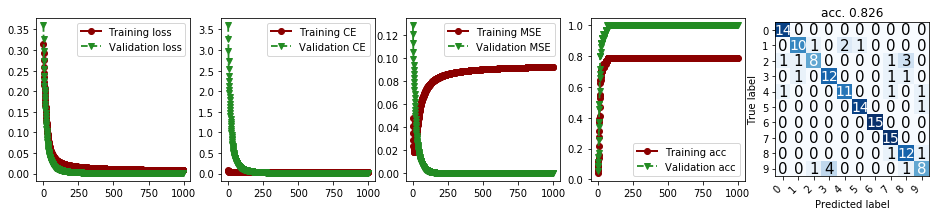

<Figure size 360x288 with 0 Axes>

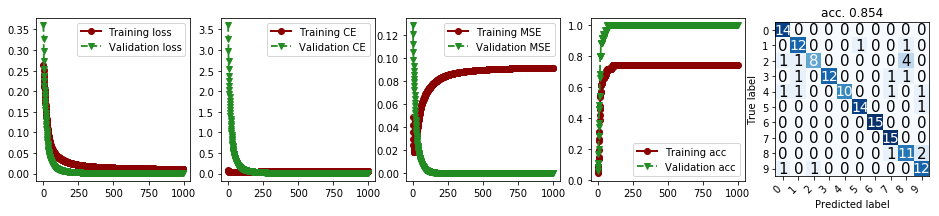

<Figure size 360x288 with 0 Axes>

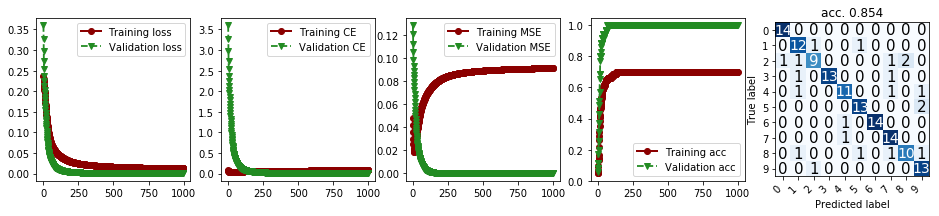

<Figure size 360x288 with 0 Axes>

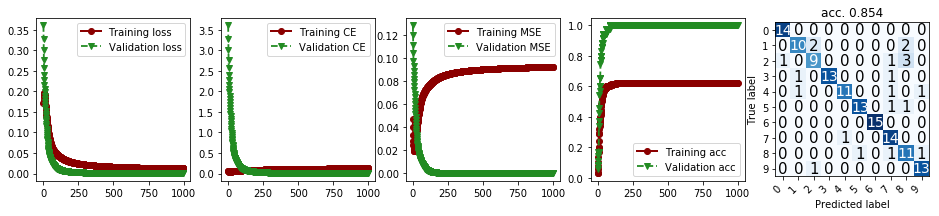

<Figure size 360x288 with 0 Axes>

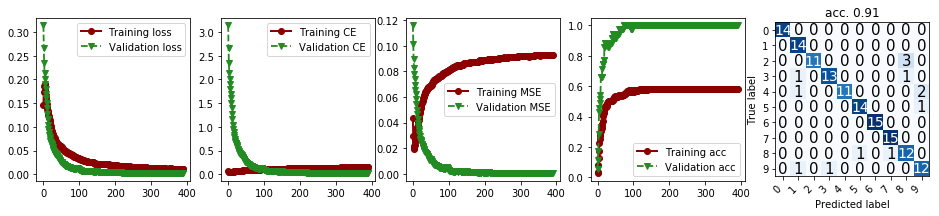

<Figure size 360x288 with 0 Axes>

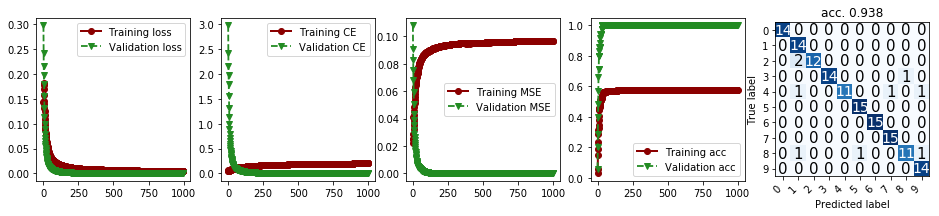

<Figure size 360x288 with 0 Axes>

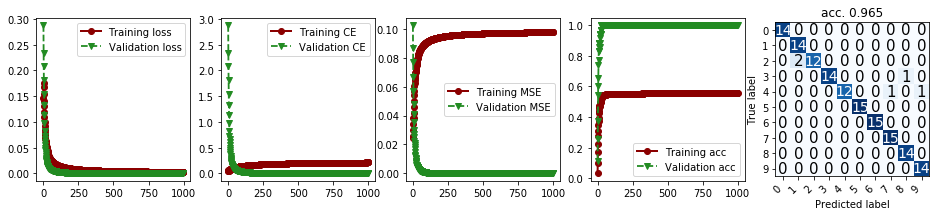

<Figure size 360x288 with 0 Axes>

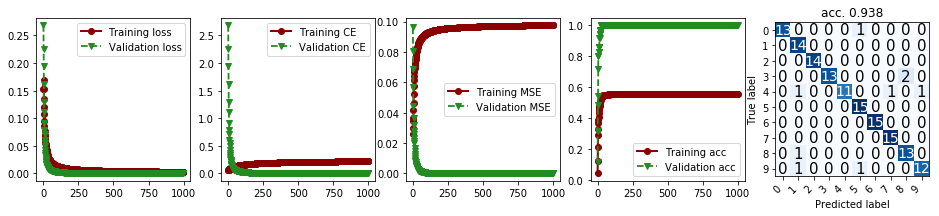

<Figure size 360x288 with 0 Axes>

In [14]:
Z_t_index = weak_to_index(Z_t, method='random_weak')
Y_v_index = weak_to_index(Y_v, method='supervised')
print("Z_t_index {}".format(Z_t_index[:5]))
print('Y_v_index {}'.format(Y_v_index[:5]))

method = 'EM M estimated'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_EM
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_t_index.shape[0])

    Z_index_t = numpy.concatenate((Z_t_index[:last_index], Y_v_index + M_0.shape[0]))

    X_tv = numpy.concatenate((X_t[:last_index], X_v), axis=0)
    numpy.random.seed(random_state)
    X_tv, Z_index_tv = shuffle(X_tv, Z_index_t)

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_tv, m[method][Z_index_tv], 
                        validation_data=(X_v, Y_v),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_te).argmax(axis=1)
    acc[method][i] = (y_pred == y_te).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_te, y_te, history)

## 4. Baseline Optimistic Superset Learning



Number of weak samples = 1617, Accuracy = 0.910

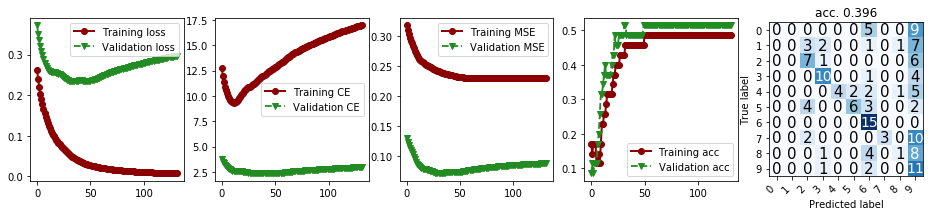

<Figure size 360x288 with 0 Axes>

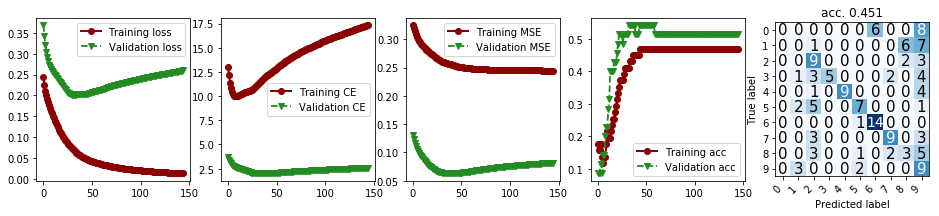

<Figure size 360x288 with 0 Axes>

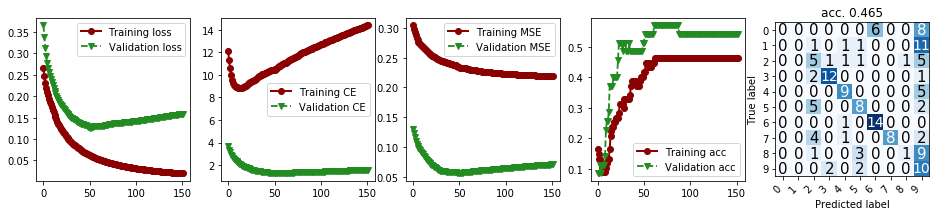

<Figure size 360x288 with 0 Axes>

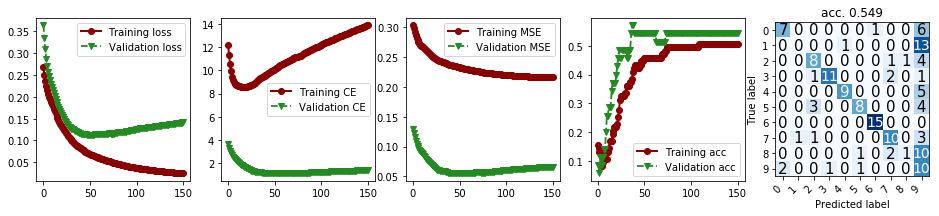

<Figure size 360x288 with 0 Axes>

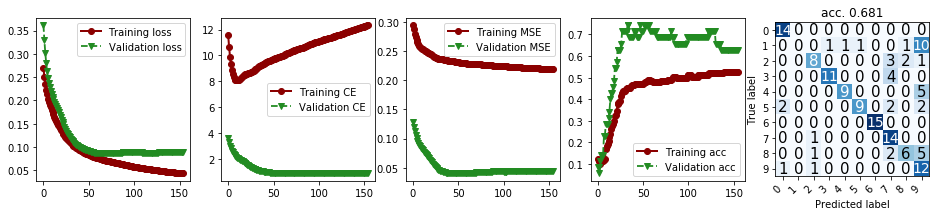

<Figure size 360x288 with 0 Axes>

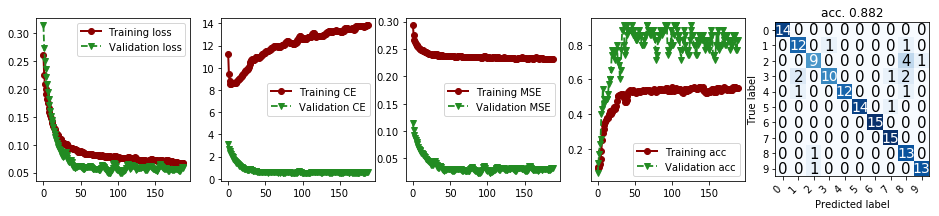

<Figure size 360x288 with 0 Axes>

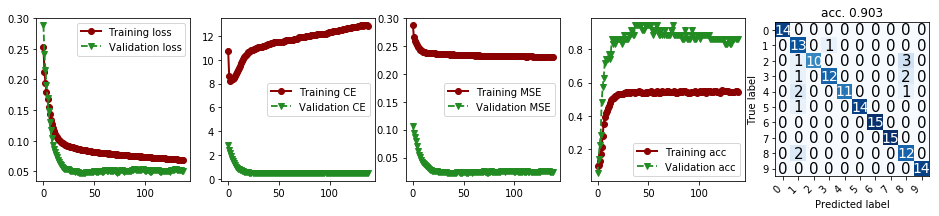

<Figure size 360x288 with 0 Axes>

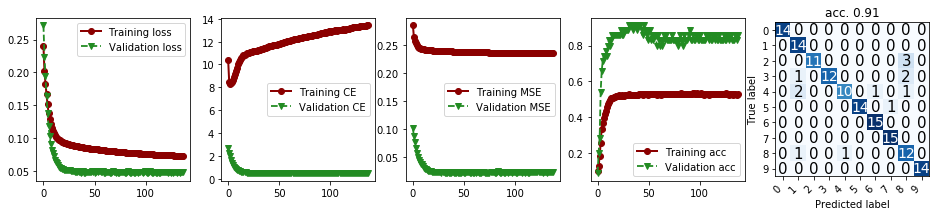

<Figure size 360x288 with 0 Axes>

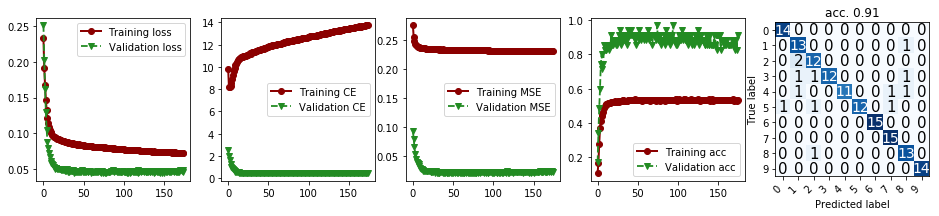

<Figure size 360x288 with 0 Axes>

In [15]:
def OSL_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    O = y_true * y_pred
    S = K.cast(K.equal(O,
                       O.max(axis=-1).repeat(O.shape[-1]
                                            ).reshape((-1, O.shape[-1]))),
               'float32')
    out = -K.stop_gradient(S) * K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'OSL'

acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_t.shape[0])

    X_tv = numpy.concatenate((X_t[:last_index], X_v), axis=0)
    Z_tv = numpy.concatenate((Z_t[:last_index], Z_v), axis=0)
    numpy.random.seed(random_state)
    X_tv, Z_tv = shuffle(X_tv, Z_tv)

    numpy.random.seed(random_state)
    model = make_model(OSL_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_tv, Z_tv, 
                        validation_data=(X_v, Y_v),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_te).argmax(axis=1)
    acc[method][i] = (y_pred == y_te).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_te, y_te, history)

# 5. Plot results

Acc. Upperbound = 0.9583333333333334
Acc. Weak
[0.33333333 0.31944444 0.27083333 0.29166667 0.51388889 0.71527778
 0.75694444 0.79861111 0.84027778]
Acc. EM Mproper
[0.8125     0.77777778 0.83333333 0.86805556 0.84027778 0.89583333
 0.86805556 0.90972222 0.90277778]
Acc. EM M estimated
[0.8125     0.82638889 0.85416667 0.85416667 0.85416667 0.90972222
 0.9375     0.96527778 0.9375    ]
Acc. OSL
[0.39583333 0.45138889 0.46527778 0.54861111 0.68055556 0.88194444
 0.90277778 0.90972222 0.90972222]
Acc. Lowerbound = 0.6736111111111112


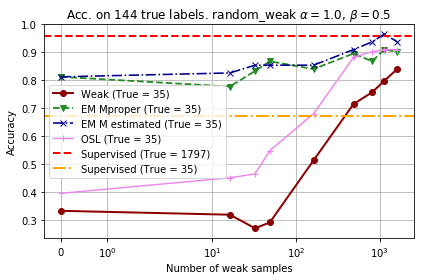

In [16]:
print('Acc. Upperbound = {}'.format(acc_upperbound))
for key, value in acc.items():
    print('Acc. {}\n{}'.format(key, value))
print('Acc. Lowerbound = {}'.format(acc_lowerbound))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r'Acc. on {} true labels. {} $\alpha={:0.1f}$, $\beta={:0.1f}$'.format(X_te.shape[0], M_method, M_alpha, M_beta))
for key, value in acc.items():
    ax.plot(list_weak_proportions*Z_t_index.shape[0], value, label='{} (True = {})'.format(key, Y_v.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_EM, 'v-', color='blue', label='EM weak + {} true labels'.format(Z_v.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_weak, 'x-', color='magenta', label='Weak + {} true labels'.format(Z_v.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_OSL, '+-', color='green', label='OSL Weak + {} true labels'.format(Z_v.shape[0]))
ax.axhline(y=acc_upperbound, color='red', lw=2,linestyle='--', label='Supervised (True = {})'.format(X.shape[0]))
ax.axhline(y=acc_lowerbound, color='orange', lw=2, linestyle='-.', label='Supervised (True = {})'.format(Z_v.shape[0]))
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy')
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.8)
ax.grid()
fig.tight_layout()
fig.savefig('full_vs_em_{}_{}_a{:02.0f}_b{:02.0f}.svg'.format(dataset_name, M_method, M_alpha*10, M_beta*10))